# Pose detection + position estimation

Generar N frames sintéticos + "labels":
- Procesar los N frames sintéticos con un modelo de pose detection ya entrenado -> keypoints 
- Entrar un modelo de aprendizaje supervisado para predecir la posición de un jugador sobre el campo

## Imports

In [128]:
import torch
import json
import csv
import tqdm
import copy
import os
import mmcv
import keras
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn  

In [143]:
# Cargar los datos de los keypoints
data = json.load(open('outputs/Blender/results_1630-16300.json'))

# Hay algunos fotogramas de los cuales no ha predecido los keypoints, por lo que hay que guardarse la posición
zeros = []

X = []
for i in range(0, len(data['instance_info'])):
    if len(data['instance_info'][i]['instances']) > 0:
        # guardarse solo la posición de las keypoints
        X.append(data['instance_info'][i]['instances'][0]['keypoints'])
    else:
        zeros.append(i)

# fotogramas que no se han podido predecir keypoints
zeros.sort(reverse = True)

X = torch.tensor(X, dtype=torch.float32)
X = torch.reshape(X, (14638, 34))
print(X.shape)

y = list()

# Cargar las posiciones de la ground truth
with open('outputs/Blender/labels-1630-16300.csv','r') as fp: # open the csv file for reading (will close when "with" block ends)
    for line in fp.readlines(): # go over remaining lines
        col = line.strip().split(";") # get the columns of data
        new_item = [int(col[1]),int(col[2])] # keep only 2nd and 3th items in a new list, starting count from 0, since this is how lists work in python
        y.append(new_item) # add the current item to the item list

# coger solo las 14660 primeros fotogramas
y = y[0:14660]

# eliminar los fotogramas de las cuales no hay keypoints predecidos
for i in zeros:
    y.pop(i)
    
y = torch.tensor(y, dtype=torch.float32)
print(y.shape)
print(y[0:10])

torch.Size([14638, 34])
torch.Size([14638, 2])
tensor([[635., 569.],
        [632., 569.],
        [631., 569.],
        [630., 570.],
        [630., 570.],
        [629., 570.],
        [628., 570.],
        [628., 570.],
        [627., 570.],
        [627., 570.]])


In [144]:
model = nn.Sequential(
    nn.Linear(34, 25),
    nn.LeakyReLU(),
    nn.Linear(25, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 7),
    nn.LeakyReLU(),
    nn.Linear(7, 2)
)

loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([10246, 34])
torch.Size([10246, 2])
torch.Size([4392, 34])
torch.Size([4392, 2])


In [145]:
# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

MSE: 131.48
RMSE: 11.47


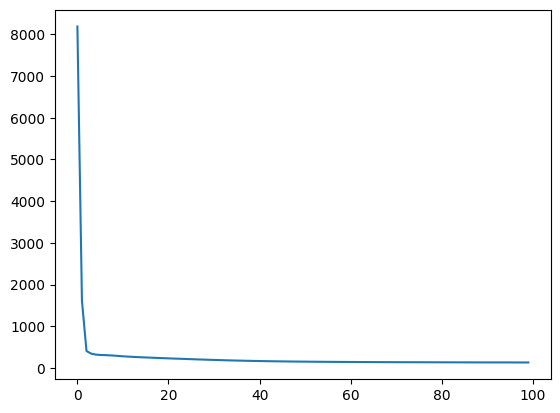

In [146]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

predictions have been saved at outputs/TopDown//results_Padel1.json


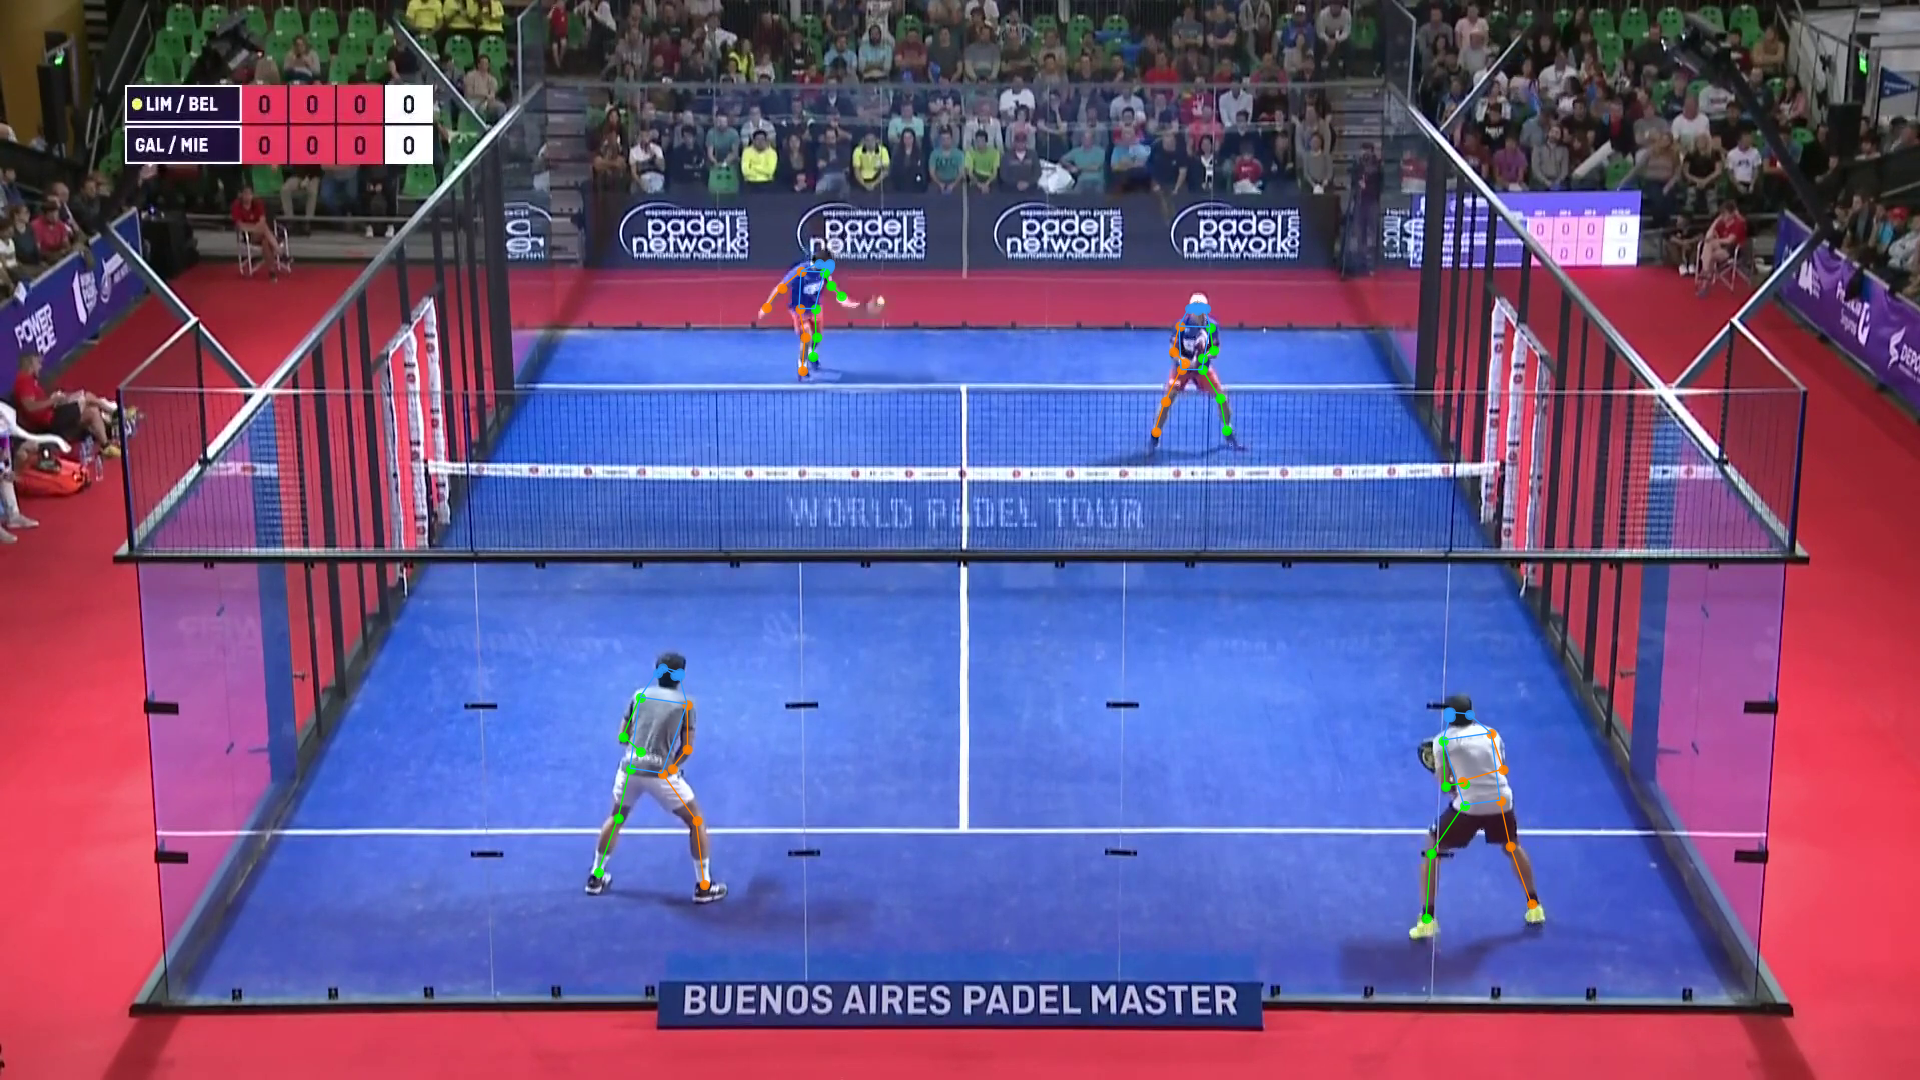

In [147]:
%run demo/topdown_demo_with_mmdet \
    demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py \
    https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth \
    configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py \
    https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth \
    --input inputs/Padel1.png --save-predictions \
    --output-root outputs/TopDown/ --device cpu

Image.open("outputs/TopDown/Padel1.png")

tensor([[ 636.9009,  907.1003],
        [1444.7687,  956.7213],
        [1169.3217,  463.7968],
        [ 793.2890,  382.1853]], grad_fn=<AddmmBackward0>)


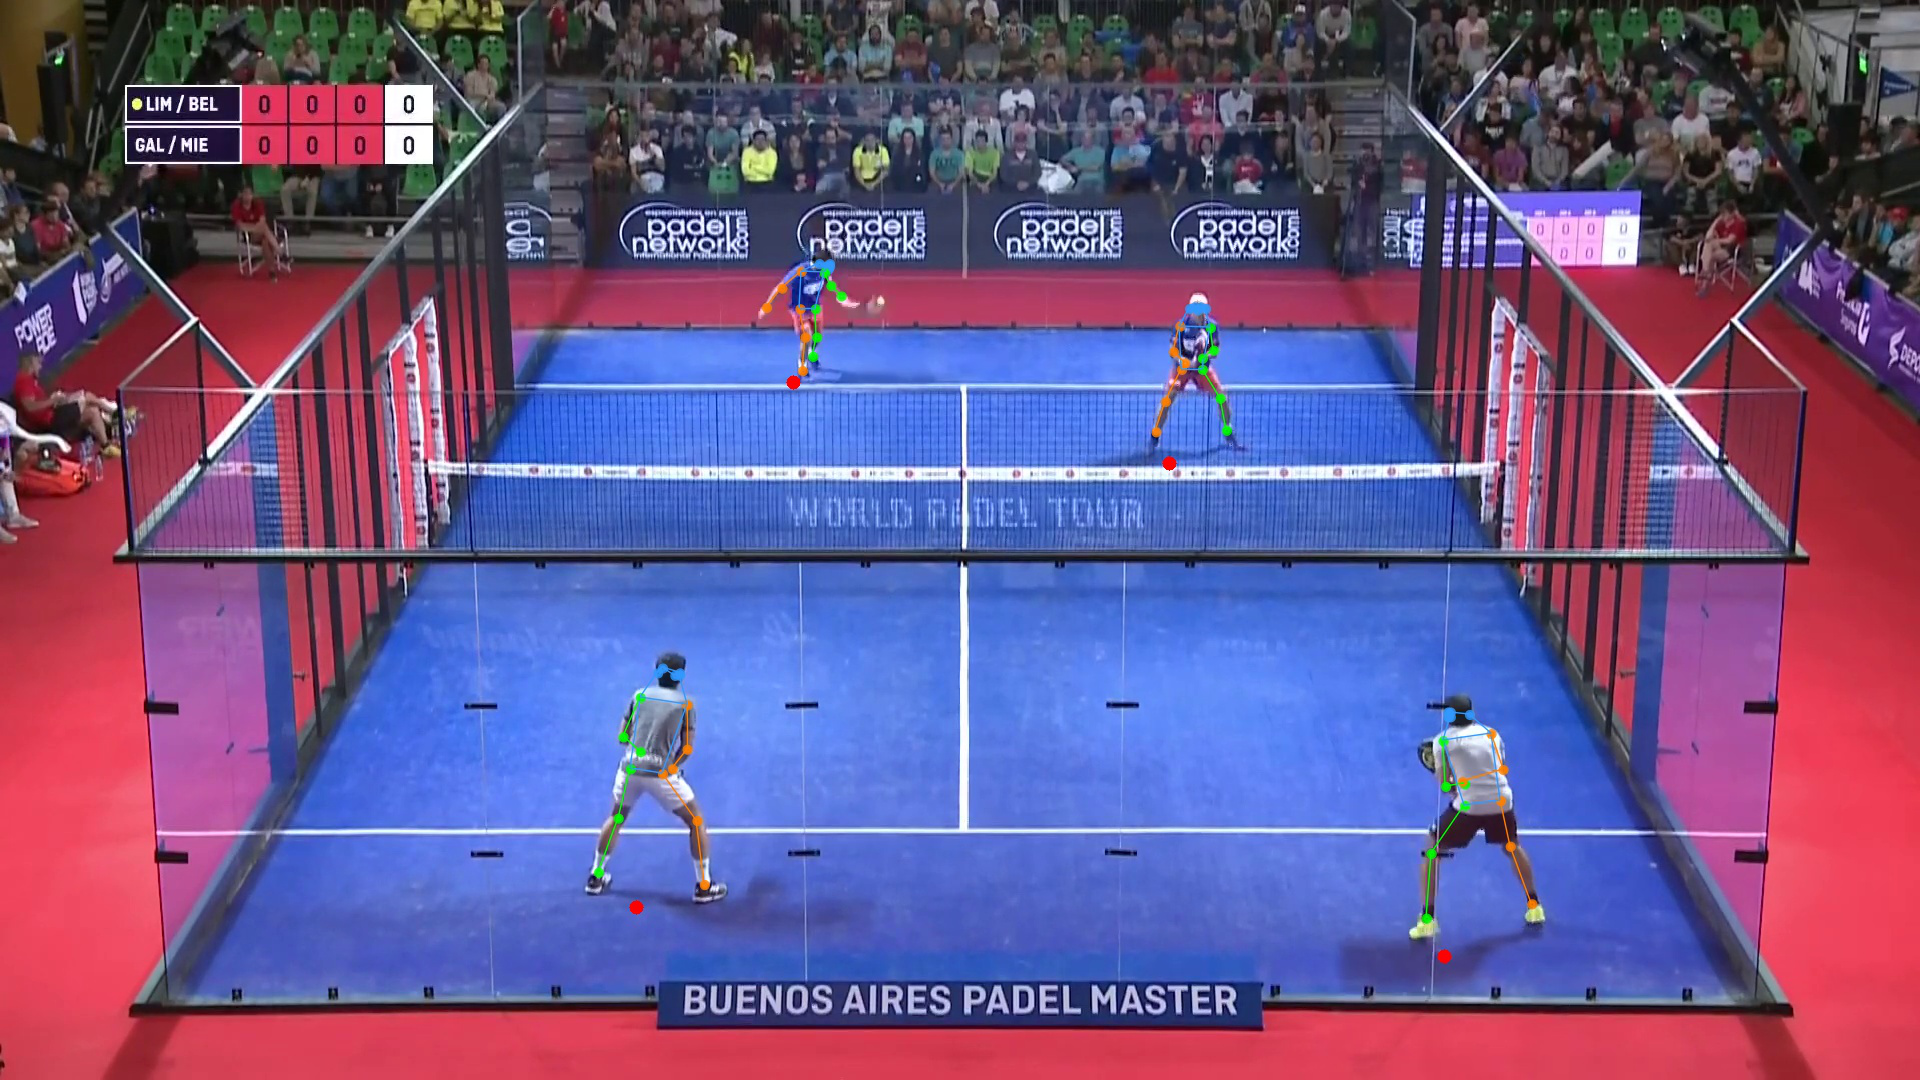

In [148]:
data = json.load(open('outputs/TopDown/results_Padel1.json'))
X = []
for i in range(0, len(data['instance_info'])):
    X.append(data['instance_info'][i]['keypoints'])
        
X = torch.tensor(X, dtype=torch.float32)
X = torch.reshape(X, (len(X), 34))
p = model(X)
print(p)

image = cv2.imread("outputs/TopDown/Padel1.png")

i = cv2.circle(image, (int(p[0][0]),int(p[0][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[1][0]),int(p[1][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[2][0]),int(p[2][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[3][0]),int(p[3][1])), radius=7, color=(0, 0, 255), thickness=-1)
filename = 'savedImage.jpg'
cv2.imwrite(filename, i)

Image.open("savedImage.jpg")

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

predictions have been saved at outputs/TopDown//results_Padel2.json
tensor([[1297.7303,  900.1129],
        [ 324.1685,  941.7333],
        [ 970.6230,  475.9513],
        [ 684.1995,  473.2148]], grad_fn=<AddmmBackward0>)


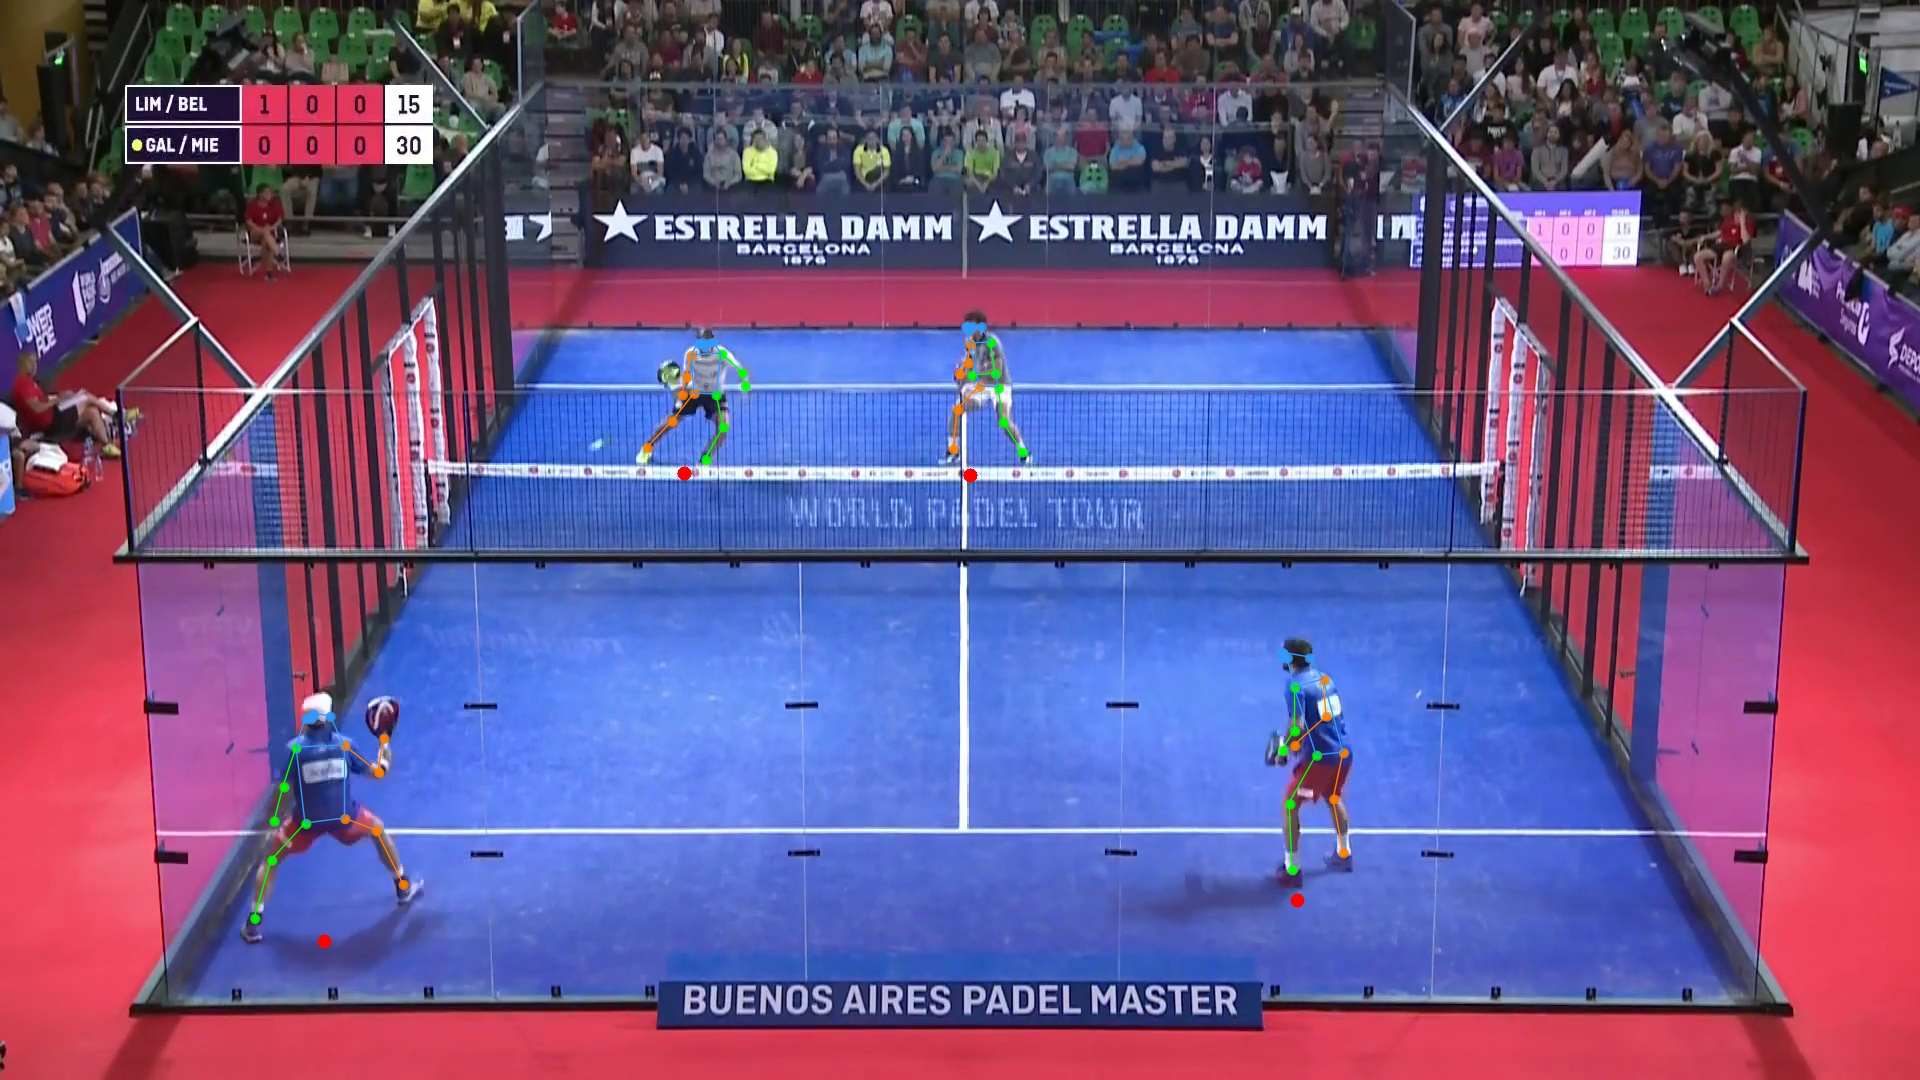

In [149]:
%run demo/topdown_demo_with_mmdet \
    demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py \
    https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth \
    configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py \
    https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth \
    --input inputs/Padel2.png --save-predictions \
    --output-root outputs/TopDown/ --device cpu

Image.open("outputs/TopDown/Padel2.png")
data = json.load(open('outputs/TopDown/results_Padel2.json'))
X = []
for i in range(0, len(data['instance_info'])):
    X.append(data['instance_info'][i]['keypoints'])
        
X = torch.tensor(X, dtype=torch.float32)
X = torch.reshape(X, (len(X), 34))
p = model(X)
print(p)

image = cv2.imread("outputs/TopDown/Padel2.png")

i = cv2.circle(image, (int(p[0][0]),int(p[0][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[1][0]),int(p[1][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[2][0]),int(p[2][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[3][0]),int(p[3][1])), radius=7, color=(0, 0, 255), thickness=-1)
filename = 'savedImage.jpg'
cv2.imwrite(filename, i)

Image.open("savedImage.jpg")

In [ ]:
# Cargar los datos de los keypoints
data = json.load(open('outputs/Blender/results_1630-16300.json'))

# Hay algunos fotogramas de los cuales no ha predecido los keypoints, por lo que hay que guardarse la posición
zeros = []

X = []
for i in range(0, len(data['instance_info'])):
    if len(data['instance_info'][i]['instances']) > 0:
        # guardarse solo la posición de las keypoints
        X.append(data['instance_info'][i]['instances'][0]['keypoints'])
    else:
        zeros.append(i)

# fotogramas que no se han podido predecir keypoints
zeros.sort(reverse = True)

y = list()

# Cargar las posiciones de la ground truth
with open('outputs/Blender/labels-1630-16300.csv','r') as fp: # open the csv file for reading (will close when "with" block ends)
    for line in fp.readlines(): # go over remaining lines
        col = line.strip().split(";") # get the columns of data
        new_item = [col[1],col[2]] # keep only 2nd and 3th items in a new list, starting count from 0, since this is how lists work in python
        y.append(new_item) # add the current item to the item list

# coger solo las 14660 primeros fotogramas
y = y[0:14660]


# eliminar los fotogramas de las cuales no hay keypoints predecidos
for i in zeros:
    y.pop(i)

### Sandardization of data ###
PredictorScaler = NDStandardScaler()
TargetVarScaler = NDStandardScaler()

# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X)
TargetVarScalerFit = TargetVarScaler.fit(y)

# Generating the standardized values of X and y
X = PredictorScalerFit.transform(X)
y = TargetVarScalerFit.transform(y)
 
# Split the data into training and testing set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

# create ANN model
model = Sequential()
    
model.add(tf.keras.layers.Flatten())
    
model.add(Dense(units=5, input_dim=17, kernel_initializer='GlorotNormal', activation='relu'))

model.add(Dense(2, kernel_initializer='GlorotNormal'))

model.compile(loss='MeanSquaredError', optimizer='adam')

model.fit(X_train, y_train ,batch_size = 2, epochs = 10, verbose=1)
 
Predictions = model.predict(X_test)

Predictions = TargetVarScalerFit.inverse_transform(Predictions)

y_test_orig = TargetVarScalerFit.inverse_transform(y_test)